# LLM - Detect AI Generated Text

In the past few years, significant advancements have been made in the development of large language models (LLMs). These models have reached a level of sophistication where the text they generate closely resembles that of human authors. This notebook explores machine learning models that can effectively determine whether an essay was authored by a student or generated by a large language model. 

The dataset includes a mixture of essays composed by students and those produced by various LLMs.

## Acknowledgments

Vanderbilt University and the Learning Agency Lab would like to thank the Bill & Melinda Gates Foundation, Schmidt Futures, and Chan Zuckerberg Initiative for their support in making this work possible.

Jules King, Perpetual Baffour, Scott Crossley, Ryan Holbrook, Maggie Demkin. (2023). LLM - Detect AI Generated Text. Kaggle. https://kaggle.com/competitions/llm-detect-ai-generated-text

# Table of Contents

- [Imports](#imports)
- [Load Data](#load-data)
- [EDA](#eda)
  - [train_prompts](#train-prompts)
  - [train_essays](#train-essays)

<a id="imports"></a>
# Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import spacy
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords, cmudict, words
from nltk.metrics import BigramAssocMeasures
from nltk.util import ngrams
import re
from collections import Counter

nltk.download('punkt')
nltk.download('cmudict')
nltk.download("words")
# Load the Dale-Chall word list
dale_chall_word_list = set(words.words())
# Load the English language model
nlp = spacy.load("en_core_web_sm")
# Load the pronunciation dictionary
prondict = cmudict.dict()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package cmudict to /usr/share/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


<a id="load"></a>
# Load Data

{test|train}_essays.csv
- `id` - A unique identifier for each essay.
- `prompt_id` - Identifies the prompt the essay was written in response to.
- `text` - The essay text itself.
- `generated` - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv.

train_prompts.csv - Essays were written in response to information in these fields.
- `prompt_id` - A unique identifier for each prompt.
- `prompt_name` - The title of the prompt.
- `instructions` - The instructions given to students.
- `source_text` - The text of the article(s) the essays were written in response to, in Markdown format. Significant paragraphs are enumerated by a numeral preceding the paragraph on the same line, as in `0 Paragraph one.\n\n1 Paragraph two.`. Essays sometimes refer to a paragraph by its numeral. Each article is preceded with its title in a heading, like `# Title`. When an author is indicated, their name will be given in the title after by. Not all articles have authors indicated. An article may have subheadings indicated like `## Subheading`.

In [2]:
train_prompts = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv")
# Load the training and testing datasets
train_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
test_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

<a id="eda"></a>
# EDA

<a id="train-prompts"></a>
## train_prompts

There are 2 prompts provided in `train_prompts`, each with a question, instructions, and 3-4 reading passages to serve as source texts.

In [3]:
train_prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


<a id="train-essays"></a>
## train_essays

- No missing values
- 1378 essays, of which 3 are generated 

In [4]:
train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
# 1378 essays in total
train_essays.shape

(1378, 4)

In [6]:
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


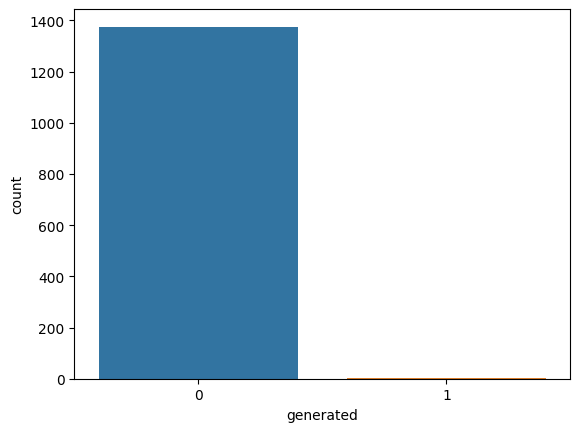

In [7]:
# Check for class balance
sns.countplot(data=train_essays, x='generated')
plt.show()

In [8]:
train_essays.groupby(['generated']).count().reset_index()

,generated,id,prompt_id,text
0,0,1375,1375,1375
1,1,3,3,3


### Word Cloud

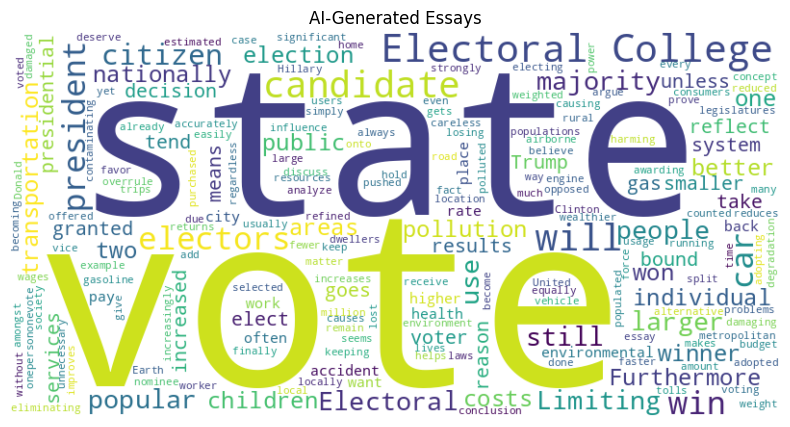

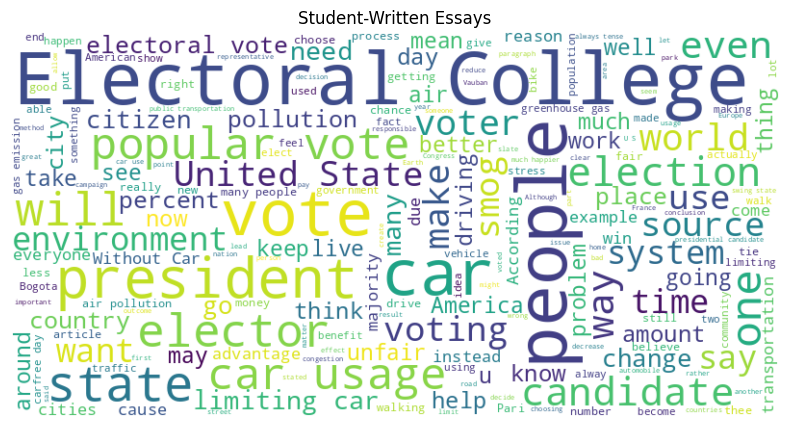

In [9]:
# Separate AI-generated and student-written essays
ai_generated_essays = train_essays[train_essays['generated'] == 1]
student_essays = train_essays[train_essays['generated'] == 0]

# Function to generate and display word clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Create word clouds for AI-generated and student-written essays
generate_wordcloud(" ".join(ai_generated_essays['text']), "AI-Generated Essays")
generate_wordcloud(" ".join(student_essays['text']), "Student-Written Essays")

#### Average Word Length

In [10]:
# Define a function to calculate the average word length
def average_word_length(text):
    words = text.split()
    total_word_length = sum(len(word) for word in words)
    return round(total_word_length / len(words), 2)

# Apply the function to create a new 'avg_word_length' column
train_essays['avg_word_length'] = train_essays['text'].apply(average_word_length)

# Calculate the median average word length for generated and non-generated essays
median_avg_word_length = train_essays.groupby(['generated'])['avg_word_length'].median().reset_index()
median_avg_word_length

,generated,avg_word_length
0,0,4.69
1,1,4.82


#### Unique words

In [11]:
# Define a function to calculate the number of unique words
def nr_unique_words(text):
    words = text.split()
    unique_words = set(word.lower() for word in words)
    return len(unique_words)

# Apply the function to create a new 'uniq_word_count' column
train_essays['uniq_word_count'] = train_essays['text'].apply(nr_unique_words)

# Calculate the median unique word count for generated and non-generated essays
median_word_count = train_essays.groupby(['generated'])['uniq_word_count'].median().reset_index()
median_word_count

,generated,uniq_word_count
0,0,251.0
1,1,117.0


#### Word Count

In [12]:
# Define a function to calculate word count
def word_count(text):
    return len(text.split())

# Apply the function to create a new 'word_count' column
train_essays['word_count'] = train_essays['text'].apply(word_count)

# Calculate the median word count for generated and non-generated essays
median_word_count = train_essays.groupby(['generated'])['word_count'].median().reset_index()
median_word_count

,generated,word_count
0,0,525.0
1,1,258.0


#### Stop Word Count

In [13]:
# Function to count stop words
def count_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    stop_words_count = sum(1 for word in words if word.lower() in stop_words)
    return stop_words_count

# Apply the function to create a new 'stop_word_count' column
train_essays['stop_word_count'] = train_essays['text'].apply(count_stop_words)

# Calculate the count of stop words for generated and non-generated essays
stop_word_count = train_essays.groupby(['generated'])['stop_word_count'].mean().reset_index()
stop_word_count

,generated,stop_word_count
0,0,265.331636
1,1,122.666667


#### Number of Sentences

In [14]:
# Define a function to count sentences
def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

# Apply the function to create a new 'nr_sentences' column
train_essays['nr_sentences'] = train_essays['text'].apply(count_sentences)

# Calculate the mean number of sentences for generated and non-generated essays
mean_sentence_count = train_essays.groupby(['generated'])['nr_sentences'].mean().reset_index()
mean_sentence_count

,generated,nr_sentences
0,0,27.658182
1,1,12.333333


#### Average Number of Clauses

In [15]:
# Define a function to calculate sentence complexity based on clauses
def sentence_complexity_clauses(text):
    sentences = sent_tokenize(text)
    clause_counts = [len(TreebankWordTokenizer().tokenize(sentence)) for sentence in sentences]
    avg_clause_count = sum(clause_counts) / len(sentences)
    return round(avg_clause_count, 2)

# Apply the function to create a new 'sentence_complexity_clauses' column
train_essays['sentence_complexity_clauses'] = train_essays['text'].apply(sentence_complexity_clauses)

# Calculate the mean sentence complexity based on clauses for generated and non-generated essays
mean_sentence_complexity_clauses = train_essays.groupby(['generated'])['sentence_complexity_clauses'].mean().reset_index()
mean_sentence_complexity_clauses

,generated,sentence_complexity_clauses
0,0,23.275105
1,1,23.250000


#### Voabulary Richness

TTR is the ratio of the number of unique words (types) to the total number of words (tokens) in a text.

In [16]:
# Preprocess the text by lowercasing, removing punctuation, and newline characters
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.replace('\n', ' ')  # Remove newline characters and replace with a space
    return text

# Define a function to calculate type-token ratio (TTR)
def calculate_ttr(text):
    words = word_tokenize(text)
    total_tokens = len(words)
    unique_tokens = len(set(words))
    ttr = unique_tokens / total_tokens
    return ttr

# Calculate TTR and create a new 'ttr' column
train_essays['ttr'] = train_essays['text'].apply(preprocess_text).apply(calculate_ttr)

# Calculate the mean TTR for generated and non-generated essays
mean_ttr = train_essays.groupby(['generated'])['ttr'].mean().reset_index()
mean_ttr

,generated,ttr
0,0,0.435546
1,1,0.502483


#### Paragraph Length

In [17]:
# Define a function to analyze the average length of paragraphs
def average_paragraph_length(text):
    paragraphs = text.split('\n\n')  # Assuming paragraphs are separated by two newline characters
    paragraph_lengths = [len(sent_tokenize(paragraph)) for paragraph in paragraphs if paragraph.strip()]  # Exclude empty paragraphs
    avg_paragraph_length = sum(paragraph_lengths) / len(paragraphs)
    return round(avg_paragraph_length, 2)

# Apply the function to create a new 'avg_paragraph_length' column
train_essays['avg_paragraph_length'] = train_essays['text'].apply(average_paragraph_length)

# Calculate the mean average paragraph length for generated and non-generated essays
mean_avg_paragraph_length = train_essays.groupby(['generated'])['avg_paragraph_length'].mean().reset_index()
mean_avg_paragraph_length

,generated,avg_paragraph_length
0,0,5.89576
1,1,9.00000


#### Readability Measures

##### Flesch-Kincaid Grade Level

The Flesch-Kincaid Grade Level is a readability score based on sentence and word length. It estimates the years of education a person needs to understand a piece of writing. The formula is given by:
$$0.39 \left( \frac{\text{total words}}{\text{total sentences}} \right) + 11.8 \left( \frac{\text{total syllables}}{\text{total words}} \right) - 15.59$$

##### Gunning Fog Index

The Gunning Fog Index assesses the complexity of written content based on the number of complex words and sentence length. The formula is given by:
$$0.4 \left( \frac{\text{total words}}{\text{total sentences}} + 100 \left( \frac{\text{complex words}}{\text{total words}} \right) \right)$$

##### Coleman-Liau Index

The Coleman-Liau Index is a readability score that relies on characters instead of syllables. It considers the number of letters, words, and sentences. The formula is given by:
$$0.0588 \left( \frac{\text{total letters}}{\text{total words}} \times 100 \right) - 0.296 \left( \frac{\text{total sentences}}{\text{total words}} \times 100 \right) - 15.8$$

##### SMOG Index

The SMOG Index evaluates text complexity based on the number of complex words and sentence length. The formula is given by:
$$1.0430 \sqrt{30 \left( \frac{\text{complex words}}{\text{total sentences}} \right) + 3.1291} + 3.4072$$

##### Automated Readability Index (ARI)

The Automated Readability Index (ARI) assesses text complexity based on characters per word, words per sentence, and a constant. The formula is given by:
$$4.71 \left( \frac{\text{total letters}}{\text{total words}} \right) + 0.5 \left( \frac{\text{total words}}{\text{total sentences}} \right) - 21.43$$

##### Simple Measure of Gobbledygook (SMOG)

The SMOG Index is another readability formula that estimates the years of education a person needs to understand a piece of writing. The formula is similar to the Gunning Fog Index.

##### Dale-Chall Readability Formula

The Dale-Chall Readability Formula considers the number of difficult words and overall sentence length. The formula is given by:
$$0.1579 \left( \frac{\text{difficult words}}{\text{total words}} \times 100 \right) + 0.0496 \left( \frac{\text{total words}}{\text{total sentences}} \times 100 \right) + 3.6365 \, \text{(if difficult words > 5\%)}$$

##### Linsear Write Formula

The Linsear Write Formula uses the number of simple and complex words to estimate readability. The formula is given by:
$$0.6 \left( \frac{\text{complex words}}{\text{total sentences}} \right) + 0.4 \left( \frac{\text{total words}}{\text{total sentences}} \right)$$

##### FORCAST Readability Formula

The FORCAST Readability Formula calculates reading ease based on the number of one-syllable, two-syllable, and complex words. The formula is given by:
$$20 - \left( \frac{\text{difficult words}}{\text{total words}} \times 100 \right)$$

In [18]:
# Function to count syllables in a word
def syllable_count(word):
    if word.lower() in prondict:
        return max([len(list(y for y in x if y[-1].isdigit())) for x in prondict[word.lower()]])
    else:
        return max(1, sum(1 for char in word if char.lower() in 'aeiou'))

# Function for Flesch-Kincaid Grade Level
def flesch_kincaid_grade_level(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    
    total_words = len(words)
    total_sentences = len(sentences)
    total_syllables = sum(syllable_count(word) for word in words)

    if total_words > 0 and total_sentences > 0:
        fk_grade_level = 0.39 * (total_words / total_sentences) + 11.8 * (total_syllables / total_words) - 15.59
        return round(fk_grade_level, 2)
    else:
        return 0.0

# Function for Gunning Fog Index
def gunning_fog_index(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    
    total_words = len(words)
    total_sentences = len(sentences)
    complex_words = count_complex_words(text)

    if total_words > 0 and total_sentences > 0:
        fog_index = 0.4 * ((total_words / total_sentences) + 100 * (complex_words / total_words))
        return round(fog_index, 2)
    else:
        return 0.0

# Function for Coleman-Liau Index
def coleman_liau_index(text):
    letters = [char for char in text if char.isalpha()]
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_letters = len(letters)
    total_words = len(words)
    total_sentences = len(sentences)

    if total_words > 0 and total_sentences > 0:
        cl_index = 0.0588 * (total_letters / total_words * 100) - 0.296 * (total_sentences / total_words * 100) - 15.8
        return round(cl_index, 2)
    else:
        return 0.0

# Function for SMOG Index
def smog_index(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_words = len(words)
    total_sentences = len(sentences)
    complex_words = count_complex_words(text)

    if total_words > 0 and total_sentences > 0:
        smog_index = 1.0430 * (30 * (complex_words / total_sentences) + 3.1291) ** 0.5 + 3.4072
        return round(smog_index, 2)
    else:
        return 0.0

# Function for Automated Readability Index (ARI)
def automated_readability_index(text):
    letters = [char for char in text if char.isalpha()]
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_letters = len(letters)
    total_words = len(words)
    total_sentences = len(sentences)

    if total_words > 0 and total_sentences > 0:
        ari = 4.71 * (total_letters / total_words) + 0.5 * (total_words / total_sentences) - 21.43
        return round(ari, 2)
    else:
        return 0.0

# Function for Simple Measure of Gobbledygook (SMOG)
def smog_index(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_words = len(words)
    total_sentences = len(sentences)
    complex_words = count_complex_words(text)

    if total_words > 0 and total_sentences > 0:
        smog_index = 1.0430 * (30 * (complex_words / total_sentences) + 3.1291) ** 0.5 + 3.4072
        return round(smog_index, 2)
    else:
        return 0.0

# Function for Dale-Chall Readability Formula
def dale_chall_readability_formula(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_words = len(words)
    total_sentences = len(sentences)
    difficult_words = count_difficult_words(text)

    if total_words > 0 and total_sentences > 0:
        dale_chall_score = 0.1579 * (difficult_words / total_words * 100) + 0.0496 * (total_words / total_sentences)
        if difficult_words / total_words > 0.05:
            dale_chall_score += 3.6365
        return round(dale_chall_score, 2)
    else:
        return 0.0

# Function for Linsear Write Formula
def linsear_write_formula(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_words = len(words)
    total_sentences = len(sentences)
    complex_words = count_complex_words(text)

    if total_words > 0 and total_sentences > 0:
        lwf = 0.6 * (complex_words / total_sentences) + 0.4 * (total_words / total_sentences)
        return round(lwf, 2)
    else:
        return 0.0

# Function for FORCAST Readability Formula
def forcast_readability_formula(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    total_words = len(words)
    total_sentences = len(sentences)
    difficult_words = count_difficult_words(text)

    if total_words > 0 and total_sentences > 0:
        forcast_score = 20 - (difficult_words / total_words * 100)
        return round(forcast_score, 2)
    else:
        return 0.0

# Function to count complex words (syllables > 2)
def count_complex_words(text):
    words = word_tokenize(text)
    return sum(1 for word in words if syllable_count(word) > 2)

# Function to count difficult words (not in Dale-Chall word list)
def count_difficult_words(text):
    words = word_tokenize(text)
    difficult_words = [word.lower() for word in words if word.lower() not in dale_chall_word_list]
    return len(difficult_words)

# Calculate readability scores for each essay
train_essays['coleman_liau_index'] = train_essays['text'].apply(coleman_liau_index)
train_essays['smog_index'] = train_essays['text'].apply(smog_index)
train_essays['automated_readability_index'] = train_essays['text'].apply(automated_readability_index)
train_essays['dale_chall_readability_formula'] = train_essays['text'].apply(dale_chall_readability_formula)
train_essays['linsear_write_formula'] = train_essays['text'].apply(linsear_write_formula)
train_essays['forcast_readability_formula'] = train_essays['text'].apply(forcast_readability_formula)

# Display the calculated readability scores
readability_scores = train_essays[['coleman_liau_index', 'smog_index', 'automated_readability_index', 'dale_chall_readability_formula', 'linsear_write_formula', 'forcast_readability_formula']]
readability_scores.head()


,coleman_liau_index,smog_index,automated_readability_index,dale_chall_readability_formula,linsear_write_formula,forcast_readability_formula
0,6.53,12.82,11.59,9.57,13.01,-8.57
1,7.20,12.92,7.95,9.62,9.39,-11.75
2,7.51,13.27,7.37,8.33,8.74,-4.23
3,5.85,11.44,5.86,8.68,7.97,-6.58
4,5.15,12.08,6.26,8.70,9.07,-6.01


In [19]:
train_essays

,id,prompt_id,text,generated,avg_word_length,uniq_word_count,word_count,stop_word_count,nr_sentences,sentence_complexity_clauses,ttr,avg_paragraph_length,coleman_liau_index,smog_index,automated_readability_index,dale_chall_readability_formula,linsear_write_formula,forcast_readability_formula
0,0059830c,0,Cars. Cars have been around since they became ...,0,4.63,297,584,264,23,28.61,0.465753,5.75,6.53,12.82,11.59,9.57,13.01,-8.57
1,005db917,0,Transportation is a large necessity in most co...,0,4.92,257,462,198,27,19.48,0.508658,5.40,7.20,12.92,7.95,9.62,9.39,-11.75
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,4.95,357,744,333,48,17.54,0.435310,9.60,7.51,13.27,7.37,8.33,8.74,-4.23
3,00940276,0,How often do you ride in a car? Do you drive a...,0,4.85,385,686,319,47,17.13,0.507289,15.67,5.85,11.44,5.86,8.68,7.97,-6.58
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,4.39,366,871,393,50,19.38,0.370800,12.50,5.15,12.08,6.26,8.70,9.07,-6.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0,4.59,208,430,227,30,16.17,0.438967,6.00,5.19,12.02,4.93,7.99,7.77,-2.47
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0,4.22,182,397,213,17,24.71,0.425693,4.25,6.12,11.09,9.44,7.19,10.91,5.24
1375,ffa247e0,0,There's a new trend that has been developing f...,0,4.79,394,749,330,36,23.72,0.473965,9.00,6.83,13.56,9.56,8.77,11.32,-5.06
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0,4.35,267,525,236,31,18.94,0.468571,6.20,4.67,11.10,5.69,8.48,8.60,-4.70


<a id="data-preprocessing"></a>
# Data Preprocessing